In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 55% 33.0M/60.3M [00:00<00:00, 84.1MB/s]
100% 60.3M/60.3M [00:00<00:00, 130MB/s] 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2
import imghdr

import tensorflow
import keras

from keras import regularizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Input
from keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from keras.applications import ResNet50V2

# Setting up Directory to save model data.

In [ ]:
# Define project name
project_name = 'Emotion_Detection1'

# List models
model_names = [
    'ResNet50_Transfer_Learning'
]

base_dir = '/content/drive/My Drive/Colab Notebooks'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for i in model_names:
  model_dir = os.path.join(project_dir, i)
  os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/drive/My Drive/Colab Notebooks/Emotion_Detection1


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files:
    # Construct the path to the current file
    file_path = os.path.join(root, file)

    try:
      # Check the file type of the current file
      file_type = imghdr.what(file_path)

      # If the file extension is not in the allowed list, remove it
      if file_type not in image_exts:
        os.remove(file_path)
      else:
        # Proceed to process the image if needed, for example, reading it with OpenCV
        img = cv2.imread(file_path)
    except Exception as e:
      # Print out the issue and the path of the problematic file
      print(f'Issue with file {file_path}. Error: {e}')
      # Optionally, remove files that cause exceptions
      os.remove(file_path)

# Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').

def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
      # Construct the full path to the item.
      item_path = os.path.join(directory, item)

      # Check if the item is a directory.
      if os.path.isdir(item_path):
        # Count the number of files in the subdirectory and add it to the dictionary.
        counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

In [ ]:
# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

        sad  fear  happy  surprise  angry  neutral  disgust
train  4830  4097   7215      3171   3995     4965      436
       sad  fear  happy  surprise  angry  neutral  disgust
test  1247  1024   1774       831    958     1233      111


<Axes: >

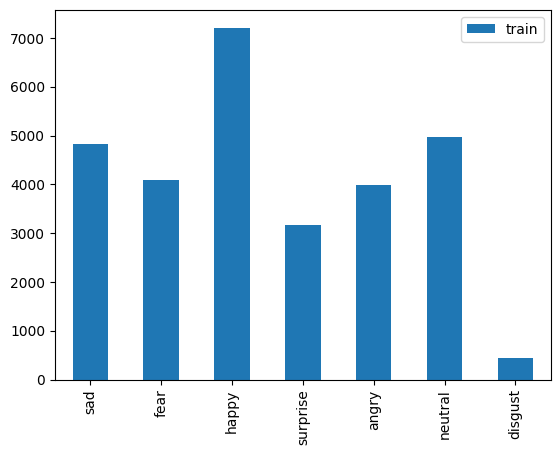

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

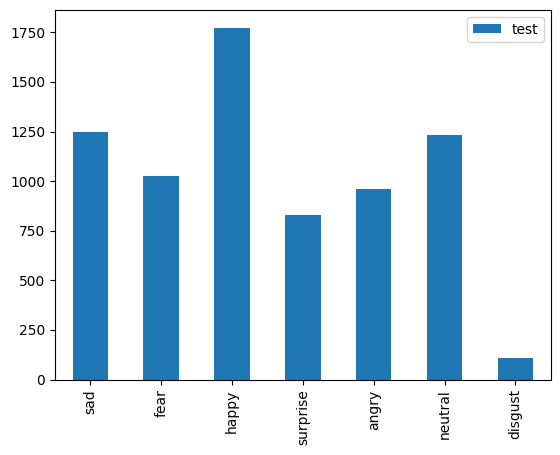

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

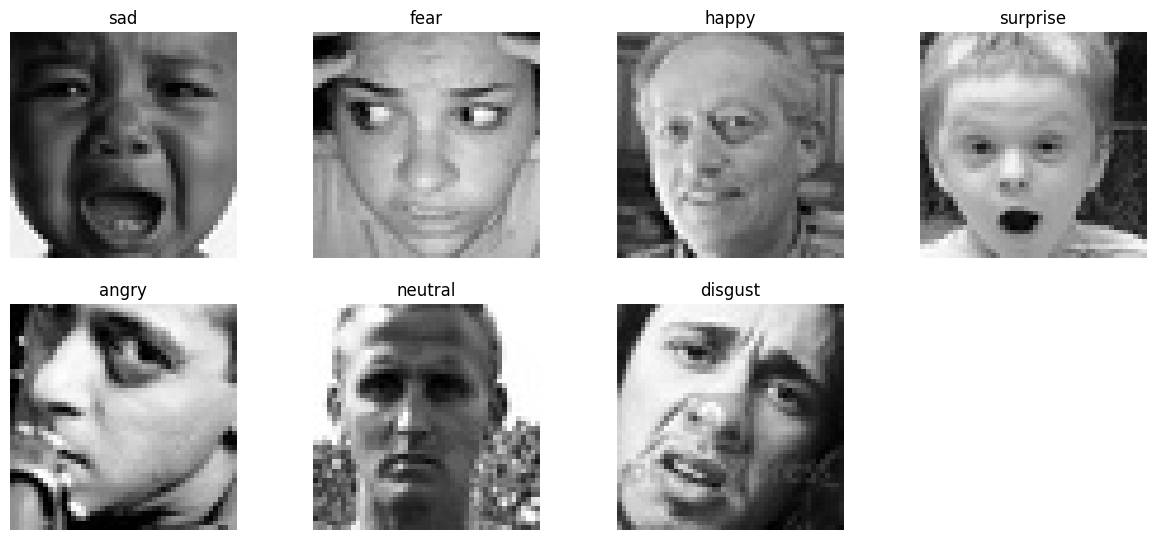

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[40])
  img = plt.imread(img_path)
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):

  image_filenames = os.listdir(directory_path)

  # If there are fewer images than requested, we'll just show them all
  if len(image_filenames) < num_images:
      print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
      num_images = len(image_filenames)

  selected_images = random.sample(image_filenames, num_images)

  fig, axes = plt.subplots(3, 3, figsize=(5, 5))
  axes = axes.ravel()

  for i, image_file in enumerate(selected_images):
      image_path = os.path.join(directory_path, image_file)
      # image = Image.open(image_path)
      image = load_img(image_path)
      axes[i].imshow(image)
      axes[i].set_title(f"Image: {class_name}")
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

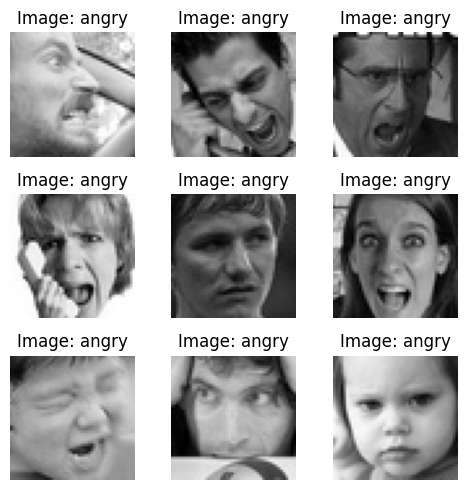

In [ ]:
plot_images_from_directory('/content/train/angry', class_name = 'angry')

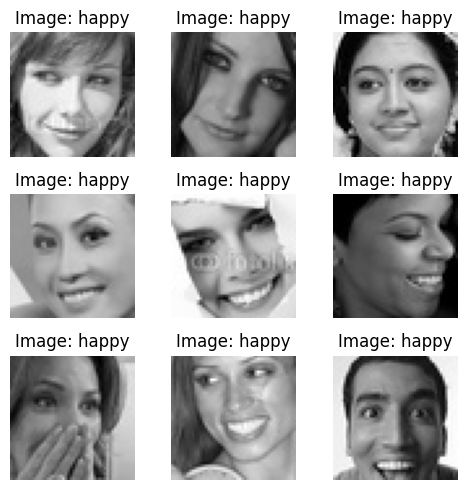

In [ ]:
plot_images_from_directory('/content/train/happy', class_name = 'happy')

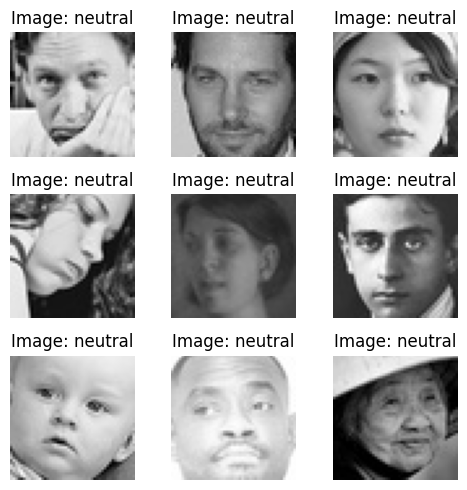

In [ ]:
plot_images_from_directory('/content/train/neutral', class_name = 'neutral')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

# Model : Transfer Leanring - ResNet50

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32)

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=32)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from keras.layers import Input

input_tensor = Input(shape=(224, 224, 3))

resnet = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')

resnet.trainable = True

for layer in resnet.layers[:-30]:
  layer.trainable = False

x = resnet.output
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 20,870,791 (79.62 MB)

 Non-trainable params: 9,125,504 (34.81 MB)

In [ ]:
# This is not correct way!

# model = Sequential()

# model.add(resnet)
# model.add(GlobalAveragePooling2D())
# model.add(BatchNormalization())

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(7, activation='softmax'))

# model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_path = '/content/drive/MyDrive/Colab Notebooks/Emotion_Detection1/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, csv_logger]

In [ ]:
## if you want to load the model than hit below cell else ignore it

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/Colab Notebooks/Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras')

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    class_weight=class_weights_dict,
                    callbacks = callbacks,
                  )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.1697 - loss: 2.3027
Epoch 1: val_loss improved from inf to 4.92495, saving model to /content/drive/MyDrive/Colab Notebooks/Emotion_Detection1/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 428s 445ms/step - accuracy: 0.1697 - loss: 2.3026 - val_accuracy: 0.1453 - val_loss: 4.9249
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.2750 - loss: 1.8936
Epoch 2: val_loss improved from 4.92495 to 1.80634, saving model to /content/drive/MyDrive/Colab Notebooks/Emotion_Detection1/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 410s 424ms/step - accuracy: 0.2750 - loss: 1.8935 - val_accuracy: 0.2705 - val_loss: 1.8063
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3219 - loss: 1.6967
Epoch 3: val_loss improved from 1.80634 to 1.61145, saving model to /content/drive/MyDrive/Colab Notebooks/Emotion_Detection1/ResNet50_Tr

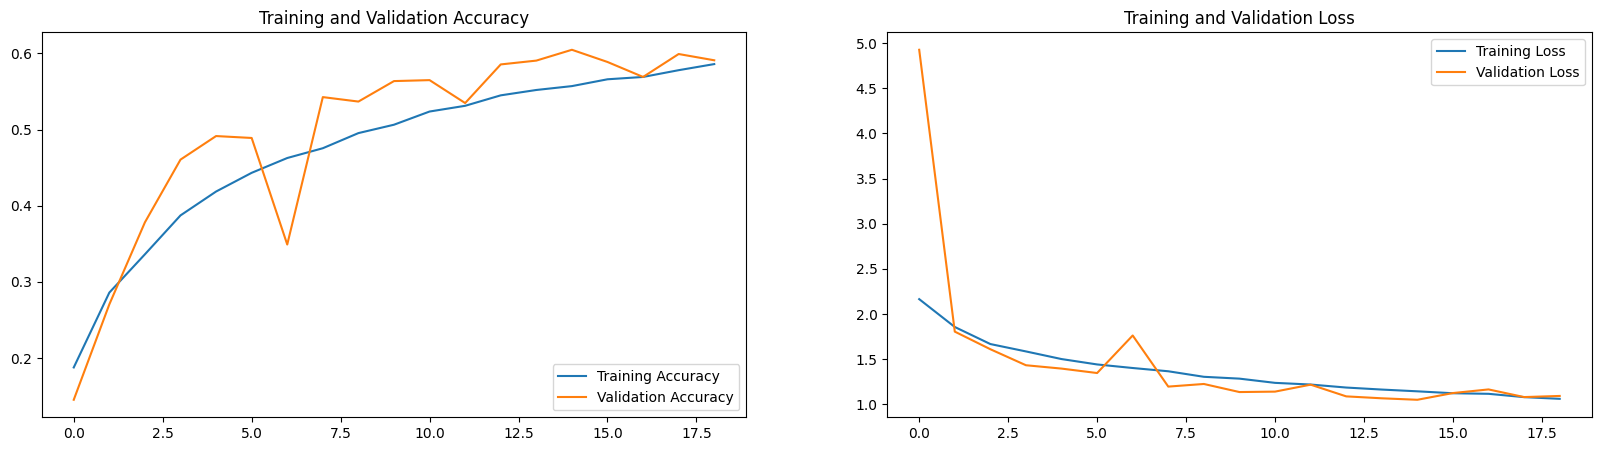

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

898/898 ━━━━━━━━━━━━━━━━━━━━ 353s 393ms/step - accuracy: 0.5986 - loss: 1.0883
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.5933 - loss: 1.0825
final train accuracy = 59.36 , validation accuracy = 60.48


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step


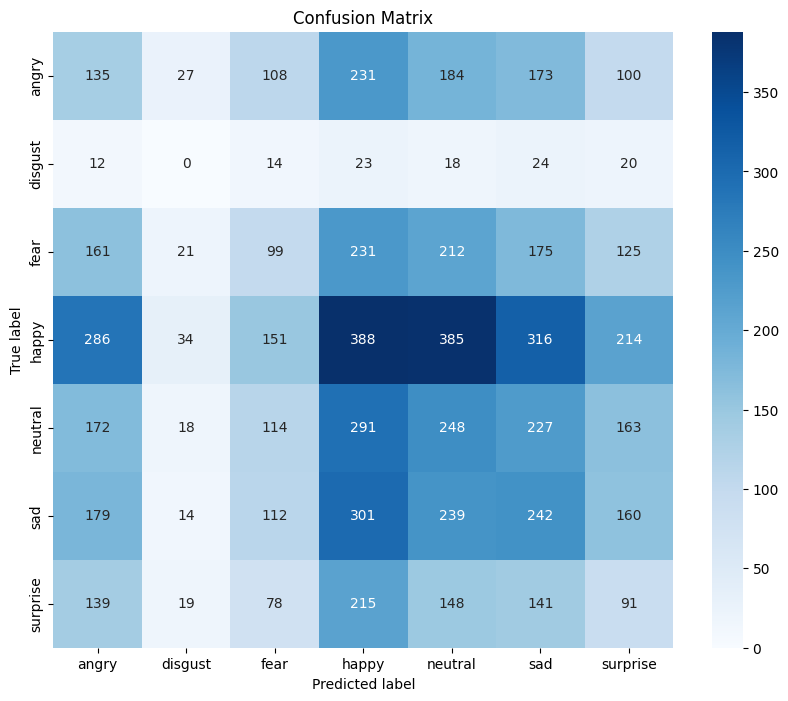

In [39]:
from sklearn.metrics import confusion_matrix

true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
from sklearn.metrics import classification_report

report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.14      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.23      0.22      0.22      1774
     neutral       0.17      0.20      0.19      1233
         sad       0.19      0.19      0.19      1247
    surprise       0.10      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



# AUC ROC plot for each class

In [43]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step


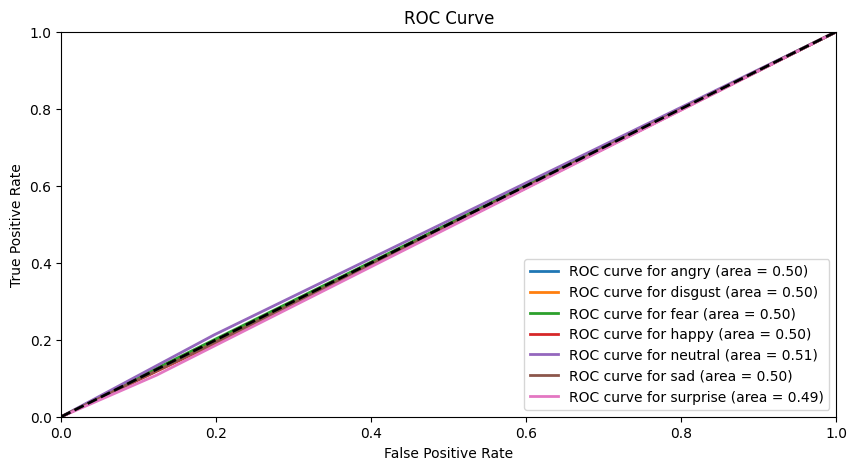

In [44]:
from sklearn.metrics import roc_curve, auc

y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
!pip install gradio

In [46]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import gradio as gr
import cv2

In [47]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras')

In [48]:
emotion_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'surprise':6}

index_to_emotion = {v:k for k, v in emotion_labels.items()}

def prepare_image(img_pil):
  img = img_pil.resize((224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  return img_array



def predict_emotion(image):
  processed_image = prepare_image(image)
  prediction = model.predict(processed_image)
  predicted_class = np.argmax(prediction, axis=1)

  predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
  return predicted_emotion



interface = gr.Interface(
    fn = predict_emotion,
    inputs = gr.Image(type='pil'),
    outputs = 'text',
    title = 'Emotion Detection',
    description = 'Upload an image and get the predicted emotion.'
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2c0a2415e13ae8ad74.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
